## Imports


In [ ]:
import numpy as np
import pickle
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torch.nn import functional as F
from tqdm.auto import tqdm
from PIL import Image
from torch.utils.data import Dataset
from MyDataset import MyDataset
%matplotlib inline

## Mount Google Drive

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


## Define DataSet


In [ ]:
# class MyDataset(Dataset):

#     def __init__(self, folders, transform=None):
#         self.folders, self.labels = self.get_labels(folders)
#         self.transform = transform

#     def __len__(self):
#         return len(self.folders)
    
#     def __getitem__(self, idx):
#         folder_id = self.folders[idx]
        
#         try:
#             with open(folder_id, 'rb') as f:
#                 color_img = pickle.load(f)
#         except EOFError:
#             print(folder_id)

#         # img process
#         for i in range(color_img.shape[0]):
#             if np.ptp(color_img[i, :, :]) != 0:
#                 color_img[i,:,:] = (color_img[i,:,:] - np.min(color_img[i,:,:])) / np.ptp(color_img[i,:,:])
#         color_img = color_img.transpose((1,2,0))

#         # img process
#         c1 = color_img[:,:,0]
#         c2 = color_img[:,:,1]
#         c3 = color_img[:,:,2]
#         c4 = color_img[:,:,3]
        
#         c1 = np.expand_dims(c1, axis=2)
#         c2 = np.expand_dims(c2, axis=2)
#         c3 = np.expand_dims(c3, axis=2)
#         c4 = np.expand_dims(c4, axis=2)

#         color_img = np.concatenate((c1, c2, c3, c4), axis=2)
#         for i in range(color_img.shape[2]):
#             if np.ptp(color_img[:,:,i]) == 0:
#                 continue
#             color_img[:,:,i] = (color_img[:,:,i] - np.min(color_img[:,:,i])) / np.ptp(color_img[:,:,i])

#         # img process, tranform
#         if self.transform is not None:
#             color_img = np.uint8(255*color_img)
#             color_img = Image.fromarray(color_img)
#             color_img = self.transform(color_img)

#         return color_img, self.labels[idx]


#     def get_labels(self, folders):

#         files = []
#         labels = []

#         #conding=utf8  
#         g = os.walk(folders)  

#         for path, _, file_list in g:  
#             for file_name in file_list:
#                 files.append(os.path.join(path, file_name))
#                 if 'nil_HS_H08' in file_name or 'light_HS_H08' in file_name:
#                     labels.append(0)
#                 elif 'moderate_HS_H08' in file_name:
#                     labels.append(1)
#                 else:
#                     labels.append(2)
                
#         return files, labels

### Transform raw data

In [ ]:
pre_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    #transforms.RandomCrop(200),
    #transforms.RandomVerticalFlip(),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])
val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

### Load Data

In [ ]:
train_dataset = MyDataset("./train",pre_transform)
val_dataset = MyDataset("./validate",val_transform)

In [ ]:
print("train data length: %d  valid data length % d"%(len(train_dataset),len(val_dataset)))

train data length: 1754  valid data length  306


### Visualize Traning Data

This is class MOD


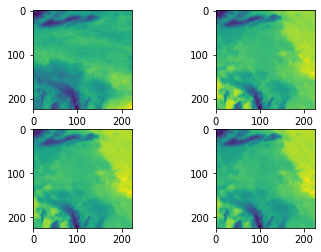

In [ ]:
img,label = train_dataset[0]
if (label == 0):
  print("This is class nil")
elif (label == 1):
  print("This is class MOD")
else:
  print("This is class SEV")

Band8 = img[0][:][:]
Band12 = img[1][:][:]
Band13 = img[2][:][:]
Band14 = img[3][:][:]
Band = [Band8,Band12,Band13,Band14]

for i in range(1,5):
    plt.subplot(2,2,i)
    plt.imshow(Band[i-1])
plt.show()


In [ ]:
#Calculate the number of samples in differnet class
train_nil_count = 0   ##591
train_MOD_count = 0   ##839
train_SEV_count = 0   ##324
valid_nil_count = 0   ##192
valid_MOD_count = 0   ##81
valid_SEV_count = 0   ##33

for i in range (0,1754):
    #print(i)
    img, label = train_dataset[i]
    if (label == 0):
        train_nil_count += 1
    elif (label == 1):
        train_MOD_count += 1
    else:
        train_SEV_count += 1
print("train set has %d nil, %d MOD, %d SEV" %(train_nil_count, train_MOD_count, train_SEV_count))

for i in range (0,306):
    #print(i)
    img, label = val_dataset[i]
    if (label == 0):
        valid_nil_count += 1
    elif (label == 1):
        valid_MOD_count += 1
    else:
        valid_SEV_count += 1
print("valid set has %d nil, %d MOD, %d SEV" %(valid_nil_count, valid_MOD_count, valid_SEV_count))

train set has 591 nil, 839 MOD, 324 SEV
valid set has 192 nil, 81 MOD, 33 SEV


## Define Model & Loss 

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(4, 16, 3, 1, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.fc1 = nn.Linear(100352, 128)
        self.fc2 = nn.Linear(128, 3)
    
    def forward(self, x):
        # x's shape = N * 4 * 224 * 224, where N is batch size
        x = self.conv1(x)
        # x's shape = N * 16 * 224 * 224
        x = F.relu(x)
        # x's shape = N * 16 * 224 * 224
        x = F.max_pool2d(x, 2)
        # x's shape = N * 16 * 112 * 112
        x = self.conv2(x)
        # x's shape = N * 32 * 112 * 112
        x = F.relu(x)
        # x's shape = N * 32 * 112 * 112
        x = F.max_pool2d(x, 2)
        # x's shape = N * 32 * 56 * 56
        x = torch.flatten(x, 1) # flat starts from the second dim
        # x's shape = N * (32 * 56 * 56) = N * 100352
        x = self.fc1(x)
        # x's shape =  N * 128
        x = F.relu(x)
        # x's shape =  N * 128
        x = self.fc2(x)
        # x's shape =  N * 3
        # output = F.log_softmax(x, dim=1)  # sometimes this is included in criterion
        return x

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True, pin_memory=False)

In [ ]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
#for LDAM
#criterion = LDAMLoss(cls_num_list = label, max_m = 0.5, s = 30, weight = weights).cuda(args.gpu)


In [ ]:
class LDAMLoss(nn.Module):
    
    def __init__(self, cls_num_list, max_m=0.5, weight=None, s=30):
        super(LDAMLoss, self).__init__()
        m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list))
        m_list = m_list * (max_m / np.max(m_list))
        m_list = torch.cuda.FloatTensor(m_list)
        self.m_list = m_list
        assert s > 0
        self.s = s
        self.weight = weight

    def forward(self, x, target):
        index = torch.zeros_like(x, dtype=torch.uint8)
        index.scatter_(1, target.data.view(-1, 1), 1)
        
        index_float = index.type(torch.cuda.FloatTensor)
        batch_m = torch.matmul(self.m_list[None, :], index_float.transpose(0,1))
        batch_m = batch_m.view((-1, 1))
        x_m = x - batch_m
    
        output = torch.where(index, x_m, x)
        return F.cross_entropy(self.s*output, target, weight=self.weight)



In [ ]:
def LDAMLoss(output, target, n_class_nil, n_class_MOD, n_class_SEV, C):
    loss = 0
    n_class = [n_class_nil, n_class_MOD, n_class_SEV]
    #output_class = output.argmax(dim=1, keepdim=False) #Shape [64], the predict class
    niter = output.shape[0] # 64 for a batch
    for i in range(niter):
        Z_y = output[i][target[i]]
        delta_y = C / (n_class[target[i]] ** (0.25) )
        nominator = torch.exp(Z_y - delta_y)
        if (target[i] == 0):
            dinominator = nominator + torch.exp(output[i][1]) + torch.exp(output[i][2])
        elif (target[i] == 1):
            dinominator = nominator + torch.exp(output[i][0]) + torch.exp(output[i][2])
        else:
            dinominator = nominator + torch.exp(output[i][0]) + torch.exp(output[i][1])
        loss += (-torch.log(nominator/dinominator))
    return loss

In [ ]:
def compute_acc(outputs, targets):
    preds = outputs.argmax(dim=1, keepdim=True)
    return preds.eq(targets.view_as(preds)).sum().item() / targets.shape[0]

In [ ]:
def performance_eval(outputs, targets):
    preds = outputs.argmax(dim=1, keepdim=False)
    targets = targets.view_as(preds)
    performance_dict = {"NIL":0.0,"MOD":0.0, "SEV":0.0 }
    for i in range(3):
        TP = targets[preds.eq(i)].eq(i).sum().item()
        FP = (~targets[preds.eq(i)].eq(i)).sum().item()
        FN = (~preds[targets.eq(i)].eq(i)).sum().item()
        Precision =  torch.true_divide(TP,(TP + FP))
        Recall = torch.true_divide(TP,(TP + FN))
        F1 = torch.true_divide(2*(Precision*Recall),(Precision+Recall))
        performance_dict[list(performance_dict.keys())[i]] = torch.tensor([Precision,Recall,F1])
    return performance_dict

In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.cnt = 0
        self.TP = torch.tensor([0,0,0])
        self.FP = torch.tensor([0,0,0])
        self.FN = torch.tensor([0,0,0])
        
    def update(self, val, outputs, targets, n=1):
        self.val = val
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt
        preds = outputs.argmax(dim=1, keepdim=True)
        preds = preds.view(-1)
        targets = targets.view(-1)
        for i in range(3):
            self.TP[i] += targets[preds.eq(i)].eq(i).sum().item()
            self.FP[i] += (~targets[preds.eq(i)].eq(i)).sum().item()
            self.FN[i] += (~preds[targets.eq(i)].eq(i)).sum().item()

In [ ]:
model = model.cuda()
criterion = criterion.cuda()

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_one_epoch():
    accs = AverageMeter()
    for X, y in tqdm(train_loader, leave=False):
        inputs = X.cuda()
        targets = y.cuda()
        #inputs = X
        #targets = y
        optimizer.zero_grad()
        # forward
        outputs = model(inputs)
        #loss = criterion(outputs, targets)
        loss = LDAMLoss(outputs,targets,591,839,324,C = 1)
        loss.backward()
        optimizer.step()
        accs.update(compute_acc(outputs, targets), outputs, targets, X.size(0))
        
    return accs
def validate_one_epoch():
    accs = AverageMeter()
    for X, y in tqdm(val_loader, leave=False):
        inputs = X.cuda()
        targets = y.cuda()
        #inputs = X
        #targets = y
        #optimizer.zero_grad()
        # forward
        outputs = model(inputs)
        #loss = criterion(outputs, targets)
        loss = LDAMLoss(outputs,targets,192,81,33,C = 1)

        #loss.backward()
        #optimizer.step()
        accs.update(compute_acc(outputs, targets), outputs, targets, X.size(0))
    return accs  

In [ ]:
best_epoch = -1
best_acc = 0.0
history_acc = []
best_model_state = model.state_dict()

for epoch in tqdm(range(25)):
    for phase in range (0,2):
      if phase == 0:
        model.train()
        accs = train_one_epoch()
        print("epoch {} train acc: {:.4f} ".format(epoch, accs.avg))
        class_names = ["NIL","MOD","SEV"]
        for i in range(3):
            Precision =  torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FP[i]))
            Recall = torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FN[i]))
            F1 = torch.true_divide(2*(Precision*Recall),(Precision+Recall))
            print("class {} Precision {:.3f} Recall{:.3f} F1 {:.3f}".format(class_names[i],Precision,Recall,F1))
            history_acc.append(accs)
      elif phase == 1:
          model.eval()
          accs = validate_one_epoch()
          print("epoch {} valid acc: {:.4f} ".format(epoch, accs.avg))
          class_names = ["NIL","MOD","SEV"]
          for i in range(3):
            Precision =  torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FP[i]))
            Recall = torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FN[i]))
            F1 = torch.true_divide(2*(Precision*Recall),(Precision+Recall))
            print("class {} Precision {:.3f} Recall{:.3f} F1 {:.3f}".format(class_names[i],Precision,Recall,F1))
            #history_acc.append(accs)  
          if accs.avg > best_acc:
            best_acc = accs.avg
            best_epoch = epoch
            best_model_state = model.state_dict()                  

print(f'[Info] best val acc: {best_acc:.2%} at {best_epoch+1}th epoch')
      


epoch 0 train acc: 0.4852 
class NIL Precision 0.480 Recall0.347 F1 0.403
class MOD Precision 0.505 Recall0.760 F1 0.607
class SEV Precision 0.125 Recall0.025 F1 0.041


epoch 0 valid acc: 0.3889 
class NIL Precision 0.975 Recall0.203 F1 0.336
class MOD Precision 0.301 Recall0.988 F1 0.461
class SEV Precision nan Recall0.000 F1 nan


epoch 1 train acc: 0.5542 
class NIL Precision 0.740 Recall0.303 F1 0.430
class MOD Precision 0.524 Recall0.945 F1 0.675
class SEV Precision nan Recall0.000 F1 nan


epoch 1 valid acc: 0.3889 
class NIL Precision 0.974 Recall0.198 F1 0.329
class MOD Precision 0.303 Recall1.000 F1 0.466
class SEV Precision nan Recall0.000 F1 nan


epoch 2 train acc: 0.5696 
class NIL Precision 0.755 Recall0.354 F1 0.482
class MOD Precision 0.535 Recall0.942 F1 0.682
class SEV Precision nan Recall0.000 F1 nan


epoch 2 valid acc: 0.4183 
class NIL Precision 0.941 Recall0.250 F1 0.395
class MOD Precision 0.314 Recall0.988 F1 0.476
class SEV Precision nan Recall0.000 F1 nan


epoch 3 train acc: 0.5804 
class NIL Precision 0.737 Recall0.403 F1 0.521
class MOD Precision 0.544 Recall0.923 F1 0.684
class SEV Precision 0.750 Recall0.019 F1 0.036


epoch 3 valid acc: 0.4085 
class NIL Precision 0.920 Recall0.240 F1 0.380
class MOD Precision 0.309 Recall0.975 F1 0.469
class SEV Precision nan Recall0.000 F1 nan


epoch 4 train acc: 0.5929 
class NIL Precision 0.738 Recall0.428 F1 0.542
class MOD Precision 0.557 Recall0.932 F1 0.697
class SEV Precision 0.833 Recall0.015 F1 0.030


epoch 4 valid acc: 0.4935 
class NIL Precision 0.880 Recall0.380 F1 0.531
class MOD Precision 0.339 Recall0.914 F1 0.495
class SEV Precision 0.800 Recall0.121 F1 0.211


epoch 5 train acc: 0.6192 
class NIL Precision 0.688 Recall0.516 F1 0.590
class MOD Precision 0.591 Recall0.890 F1 0.710
class SEV Precision 0.723 Recall0.105 F1 0.183


epoch 5 valid acc: 0.4902 
class NIL Precision 0.900 Recall0.375 F1 0.529
class MOD Precision 0.336 Recall0.914 F1 0.492
class SEV Precision 0.667 Recall0.121 F1 0.205


epoch 6 train acc: 0.6494 
class NIL Precision 0.750 Recall0.518 F1 0.613
class MOD Precision 0.611 Recall0.921 F1 0.735
class SEV Precision 0.741 Recall0.185 F1 0.296


epoch 6 valid acc: 0.5915 
class NIL Precision 0.796 Recall0.609 F1 0.690
class MOD Precision 0.395 Recall0.765 F1 0.521
class SEV Precision 1.000 Recall0.061 F1 0.114


epoch 7 train acc: 0.6876 
class NIL Precision 0.772 Recall0.619 F1 0.687
class MOD Precision 0.649 Recall0.900 F1 0.754
class SEV Precision 0.733 Recall0.262 F1 0.386


epoch 7 valid acc: 0.5752 
class NIL Precision 0.866 Recall0.505 F1 0.638
class MOD Precision 0.399 Recall0.877 F1 0.548
class SEV Precision 0.500 Recall0.242 F1 0.327


epoch 8 train acc: 0.7315 
class NIL Precision 0.801 Recall0.680 F1 0.736
class MOD Precision 0.694 Recall0.901 F1 0.784
class SEV Precision 0.772 Recall0.386 F1 0.514


epoch 8 valid acc: 0.5131 
class NIL Precision 0.894 Recall0.396 F1 0.549
class MOD Precision 0.352 Recall0.914 F1 0.509
class SEV Precision 0.636 Recall0.212 F1 0.318


epoch 9 train acc: 0.7873 
class NIL Precision 0.823 Recall0.765 F1 0.793
class MOD Precision 0.763 Recall0.903 F1 0.828
class SEV Precision 0.807 Recall0.528 F1 0.638


epoch 9 valid acc: 0.5654 
class NIL Precision 0.944 Recall0.438 F1 0.598
class MOD Precision 0.398 Recall0.963 F1 0.563
class SEV Precision 0.524 Recall0.333 F1 0.407


epoch 10 train acc: 0.8187 
class NIL Precision 0.829 Recall0.782 F1 0.805
class MOD Precision 0.799 Recall0.907 F1 0.850
class SEV Precision 0.869 Recall0.657 F1 0.749


epoch 10 valid acc: 0.6144 
class NIL Precision 0.909 Recall0.521 F1 0.662
class MOD Precision 0.431 Recall0.852 F1 0.573
class SEV Precision 0.528 Recall0.576 F1 0.551


epoch 11 train acc: 0.8609 
class NIL Precision 0.865 Recall0.846 F1 0.855
class MOD Precision 0.845 Recall0.930 F1 0.885
class SEV Precision 0.909 Recall0.710 F1 0.797


epoch 11 valid acc: 0.4869 
class NIL Precision 0.921 Recall0.302 F1 0.455
class MOD Precision 0.350 Recall0.926 F1 0.508
class SEV Precision 0.552 Recall0.485 F1 0.516


epoch 12 train acc: 0.8860 
class NIL Precision 0.905 Recall0.843 F1 0.873
class MOD Precision 0.871 Recall0.940 F1 0.904
class SEV Precision 0.896 Recall0.824 F1 0.859


epoch 12 valid acc: 0.6732 
class NIL Precision 0.903 Recall0.630 F1 0.742
class MOD Precision 0.479 Recall0.852 F1 0.613
class SEV Precision 0.571 Recall0.485 F1 0.525


epoch 13 train acc: 0.9270 
class NIL Precision 0.940 Recall0.907 F1 0.923
class MOD Precision 0.919 Recall0.963 F1 0.941
class SEV Precision 0.925 Recall0.870 F1 0.897


epoch 13 valid acc: 0.5654 
class NIL Precision 0.892 Recall0.432 F1 0.582
class MOD Precision 0.407 Recall0.889 F1 0.558
class SEV Precision 0.500 Recall0.545 F1 0.522


epoch 14 train acc: 0.9510 
class NIL Precision 0.951 Recall0.949 F1 0.950
class MOD Precision 0.955 Recall0.963 F1 0.959
class SEV Precision 0.940 Recall0.923 F1 0.931


epoch 14 valid acc: 0.5719 
class NIL Precision 0.953 Recall0.427 F1 0.590
class MOD Precision 0.403 Recall0.901 F1 0.557
class SEV Precision 0.513 Recall0.606 F1 0.556


epoch 15 train acc: 0.9652 
class NIL Precision 0.961 Recall0.964 F1 0.963
class MOD Precision 0.962 Recall0.973 F1 0.967
class SEV Precision 0.981 Recall0.948 F1 0.964


epoch 15 valid acc: 0.6275 
class NIL Precision 0.951 Recall0.505 F1 0.660
class MOD Precision 0.451 Recall0.914 F1 0.604
class SEV Precision 0.525 Recall0.636 F1 0.575


epoch 16 train acc: 0.9789 
class NIL Precision 0.973 Recall0.980 F1 0.976
class MOD Precision 0.982 Recall0.983 F1 0.983
class SEV Precision 0.981 Recall0.966 F1 0.974


epoch 16 valid acc: 0.7124 
class NIL Precision 0.827 Recall0.724 F1 0.772
class MOD Precision 0.534 Recall0.765 F1 0.629
class SEV Precision 0.773 Recall0.515 F1 0.618


epoch 17 train acc: 0.9766 
class NIL Precision 0.966 Recall0.973 F1 0.970
class MOD Precision 0.980 Recall0.981 F1 0.980
class SEV Precision 0.987 Recall0.972 F1 0.980


epoch 17 valid acc: 0.7026 
class NIL Precision 0.868 Recall0.682 F1 0.764
class MOD Precision 0.537 Recall0.802 F1 0.644
class SEV Precision 0.559 Recall0.576 F1 0.567


epoch 18 train acc: 0.9812 
class NIL Precision 0.980 Recall0.981 F1 0.981
class MOD Precision 0.980 Recall0.985 F1 0.982
class SEV Precision 0.987 Recall0.972 F1 0.980


epoch 18 valid acc: 0.6111 
class NIL Precision 0.894 Recall0.526 F1 0.662
class MOD Precision 0.443 Recall0.815 F1 0.574
class SEV Precision 0.455 Recall0.606 F1 0.519


epoch 19 train acc: 0.9783 
class NIL Precision 0.980 Recall0.975 F1 0.977
class MOD Precision 0.977 Recall0.979 F1 0.978
class SEV Precision 0.979 Recall0.985 F1 0.982


epoch 19 valid acc: 0.6797 
class NIL Precision 0.914 Recall0.609 F1 0.731
class MOD Precision 0.500 Recall0.852 F1 0.630
class SEV Precision 0.550 Recall0.667 F1 0.603


epoch 20 train acc: 0.9937 
class NIL Precision 0.992 Recall0.998 F1 0.995
class MOD Precision 0.994 Recall0.994 F1 0.994
class SEV Precision 0.997 Recall0.985 F1 0.991


epoch 20 valid acc: 0.5131 
class NIL Precision 0.914 Recall0.333 F1 0.489
class MOD Precision 0.369 Recall0.889 F1 0.522
class SEV Precision 0.512 Recall0.636 F1 0.568


epoch 21 train acc: 0.9555 
class NIL Precision 0.899 Recall0.983 F1 0.939
class MOD Precision 0.985 Recall0.932 F1 0.958
class SEV Precision 0.997 Recall0.966 F1 0.981


epoch 21 valid acc: 0.6275 
class NIL Precision 0.627 Recall1.000 F1 0.771
class MOD Precision nan Recall0.000 F1 nan
class SEV Precision nan Recall0.000 F1 nan


epoch 22 train acc: 0.3369 
class NIL Precision 0.337 Recall1.000 F1 0.504
class MOD Precision nan Recall0.000 F1 nan
class SEV Precision nan Recall0.000 F1 nan


epoch 22 valid acc: 0.6275 
class NIL Precision 0.627 Recall1.000 F1 0.771
class MOD Precision nan Recall0.000 F1 nan
class SEV Precision nan Recall0.000 F1 nan


epoch 23 train acc: 0.3369 
class NIL Precision 0.337 Recall1.000 F1 0.504
class MOD Precision nan Recall0.000 F1 nan
class SEV Precision nan Recall0.000 F1 nan


epoch 23 valid acc: 0.6275 
class NIL Precision 0.627 Recall1.000 F1 0.771
class MOD Precision nan Recall0.000 F1 nan
class SEV Precision nan Recall0.000 F1 nan


epoch 24 train acc: 0.3369 
class NIL Precision 0.337 Recall1.000 F1 0.504
class MOD Precision nan Recall0.000 F1 nan
class SEV Precision nan Recall0.000 F1 nan


epoch 24 valid acc: 0.6275 
class NIL Precision 0.627 Recall1.000 F1 0.771
class MOD Precision nan Recall0.000 F1 nan
class SEV Precision nan Recall0.000 F1 nan

[Info] best val acc: 71.24% at 17th epoch


ValueError: ignored

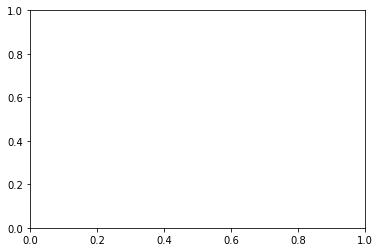

In [ ]:
accuracy = []
for accs in history_acc:
    accuracy.append(accs.avg)
plt.plot(range(25),accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
model.eval()
for X, y in tqdm(val_loader, leave=False):
    inputs = X.cuda()
    outputs = model(inputs)
    print(outputs.shape)
    print(y.shape)
    print("y actual:",y)
    print(outputs)
    #print(outputs.argmax(dim=1, keepdim=True))
    acc = compute_acc(outputs.cpu(), y)
    print(f'Test Acc: {acc}')

torch.Size([64, 3])
torch.Size([64])
y actual: tensor([0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
        1, 0, 2, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 2, 0, 1, 0, 0, 0, 0, 2, 0, 0,
        1, 1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
tensor([[ 0.0557, -0.0920,  0.0841],
        [ 0.0612, -0.0929,  0.0764],
        [ 0.0699, -0.0883,  0.0889],
        [ 0.0518, -0.0895,  0.0689],
        [ 0.0615, -0.0905,  0.0743],
        [ 0.0518, -0.0895,  0.0689],
        [ 0.0585, -0.0943,  0.0914],
        [ 0.0630, -0.0896,  0.0890],
        [ 0.0639, -0.0890,  0.0843],
        [ 0.0683, -0.0923,  0.0971],
        [ 0.0679, -0.0913,  0.0892],
        [ 0.0671, -0.0915,  0.0930],
        [ 0.0619, -0.0930,  0.0957],
        [ 0.0628, -0.0898,  0.0709],
        [ 0.0616, -0.0865,  0.0770],
        [ 0.0664, -0.0922,  0.0782],
        [ 0.0518, -0.0895,  0.0689],
        [ 0.0668, -0.0923,  0.0845],
        [ 0.0571, -0.0908,  0.0887],
        [ 0.0518, -0.0895,  0.068

In [ ]:
print(outputs.shape[0])
output_class = outputs.argmax(dim=1, keepdim=False)
print(output_class)

50
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2], device='cuda:0')


In [ ]:
print(y.shape)

torch.Size([50])
